In [1]:
import cptac
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics

In [2]:
cptac.download("brca")
cptac.download("ccrcc")
cptac.download("colon")
cptac.download("endometrial")
cptac.download("gbm")
cptac.download("luad")
cptac.download("ovarian")
cptac.download("hnscc")
cptac.download("lscc")

brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 15)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 18)


version 3scc v3.2.......                 


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 19)


In [3]:
## 2D Histogram
def get_gene_list(tissue):
    #Returns a list of the genes that are in both proteomics and transcriptomics
    gene_list = []
    prot = tissue.get_proteomics()
    if isinstance(prot.columns, pd.MultiIndex):
        prot = prot.columns.get_level_values(0)
    trans = tissue.get_transcriptomics()
    if isinstance(trans.columns, pd.MultiIndex):
        trans = trans.columns.get_level_values(0)
    for i in prot:
        if i in trans and i not in gene_list:
            gene_list.append(i)
    return gene_list


def correlation_list(tissue, gene_list, valid_sample_number = 30, tissue_type = "both"):
    #Returns a list of lists containing the name of the gene and the correlation
    corr_list = []
    pval_list = []
    prot = tissue.get_proteomics(tissue_type)
    if isinstance(prot.columns, pd.MultiIndex):
        prot = cptac.utils.reduce_multiindex(prot, levels_to_drop = "Database_ID")
    
    trans = tissue.get_transcriptomics(tissue_type)
    if isinstance(trans.columns, pd.MultiIndex):
        trans = cptac.utils.reduce_multiindex(trans, levels_to_drop = "Database_ID")
        
    prot_index_values = list(prot.index.values)
    trans_index_values = list(trans.index.values)
    

    for found_index in prot_index_values:
        if found_index not in trans_index_values:
            prot = prot.drop(index=found_index)
    for found_index in trans_index_values:
        if found_index not in prot_index_values:
            trans = trans.drop(index=found_index)
        
    for gene in gene_list:
        prot_measurements = prot[gene]
        prot_count = len(prot_measurements.dropna())
        
        trans_measurements = trans[gene]
        trans_count = len(trans_measurements.dropna())
        
        if prot_count < valid_sample_number or trans_count < valid_sample_number:
            continue
            
        nan_indices = set()
        prot_indices = list(prot_measurements.index.values)
        trans_indices = list(trans_measurements.index.values)
        
        #Here we are only currently taking the first column of multi_indices
        if isinstance(prot_measurements, pd.core.frame.DataFrame): 
            prot_measurements = prot_measurements.iloc[:,0]
        if isinstance(trans_measurements, pd.core.frame.DataFrame):
            trans_measurements = trans_measurements.iloc[:,0]
        for i in range(len(prot_measurements)):
            if math.isnan(prot_measurements[i]):
                nan_indices.add(prot_indices[i])
                
        for i in range(len(trans_measurements)):
            if math.isnan(trans_measurements[i]):
                nan_indices.add(trans_indices[i])
        
        nan_indices = list(nan_indices)
        prot_measurements = prot_measurements.drop(nan_indices)
        trans_measurements = trans_measurements.drop(nan_indices)
        
        correlation,pval = scipy.stats.pearsonr(prot_measurements, trans_measurements)
        if math.isnan(correlation):
            continue
        corr_list.append([gene,correlation])
        pval_list.append([gene, pval])
    return corr_list, pval_list
def ret_list(li):
    #Returns a list of correlations from all genes
    ret_li = []
    for i in li:
        ret_li.append(i[1])   
    return ret_li
def minmax(val_list):
    if len(val_list) == 0:
        return np.nan, np.nan
    else:
        min_val = min(val_list)
        max_val = max(val_list)

    return (min_val, max_val)
def fill_genes_nan(all_genes, tissue_corr):
    tissue_genes = []
    for i, j  in tissue_corr:
        tissue_genes.append(i)
        
    for i in all_genes:
        if i not in tissue_genes:
            tissue_corr.append([i, np.nan])
    end_list = sorted(tissue_corr)
           
    return end_list

In [4]:
brca_gene_list = get_gene_list(brca)
ccrcc_gene_list = get_gene_list(ccrcc)
colon_gene_list = get_gene_list(colon)
gbm_gene_list = get_gene_list(gbm)
luad_gene_list = get_gene_list(luad)
ovarian_gene_list = get_gene_list(ovarian)
en_gene_list = get_gene_list(en)
hnscc_gene_list = get_gene_list(hnscc)
lscc_gene_list = get_gene_list(lscc)

brca_corr, brca_pval = correlation_list(brca, brca_gene_list, tissue_type = "tumor")
ccrcc_corr, ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list, tissue_type = "tumor")
colon_corr, colon_pval = correlation_list(colon, colon_gene_list, tissue_type = "tumor")
en_corr, en_pval = correlation_list(en, en_gene_list, tissue_type = "tumor")
gbm_corr, gbm_pval = correlation_list(gbm, gbm_gene_list, tissue_type = "tumor")
luad_corr, luad_pval = correlation_list(luad,luad_gene_list, tissue_type = "tumor")
ovarian_corr, ovarian_pval = correlation_list(ovarian, ovarian_gene_list, tissue_type = "tumor")
hnscc_corr, hnscc_pval = correlation_list(hnscc, hnscc_gene_list, tissue_type = "tumor")
lscc_corr, lscc_pval = correlation_list(lscc, lscc_gene_list, tissue_type = "tumor")

normal_brca_corr, normal_brca_pval = correlation_list(brca, brca_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ccrcc_corr, normal_ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_colon_corr, normal_colon_pval = correlation_list(colon, colon_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_en_corr, normal_en_pval = correlation_list(en, en_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_gbm_corr, normal_gbm_pval = correlation_list(gbm, gbm_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_luad_corr, normal_luad_pval = correlation_list(luad,luad_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ovarian_corr, normal_ovarian_pval = correlation_list(ovarian, ovarian_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_hnscc_corr, normal_hnscc_pval = correlation_list(hnscc, hnscc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_lscc_corr, normal_lscc_pval = correlation_list(lscc, lscc_gene_list,valid_sample_number = 7, tissue_type="normal")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 23)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 23)
C:\Users\humbe\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 27)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 23)
cptac warning: Due to dropping the specified levels, dataframe 

In [5]:
genes = brca_gene_list + ccrcc_gene_list + colon_gene_list + en_gene_list + gbm_gene_list+ luad_gene_list + ovarian_gene_list + hnscc_gene_list + lscc_gene_list
common_genes = []
for i in genes:
    if i not in common_genes:
        common_genes.append(i)
common_genes = sorted(common_genes)

In [6]:
brca_list_corr = ret_list(fill_genes_nan(common_genes, brca_corr))
ccrcc_list_corr = ret_list(fill_genes_nan(common_genes, ccrcc_corr))
colon_list_corr = ret_list(fill_genes_nan(common_genes, colon_corr))
en_list_corr = ret_list(fill_genes_nan(common_genes, en_corr))
gbm_list_corr = ret_list(fill_genes_nan(common_genes, gbm_corr))
luad_list_corr = ret_list(fill_genes_nan(common_genes, luad_corr))
ovarian_list_corr = ret_list(fill_genes_nan(common_genes, ovarian_corr))
hnscc_list_corr = ret_list(fill_genes_nan(common_genes, hnscc_corr))
lscc_list_corr = ret_list(fill_genes_nan(common_genes, lscc_corr))

median_list = []
std_list = []
sigma_list = []
range_list = []
row_size = []

for i in range(len(common_genes)):

    row = list(filter(lambda x:not math.isnan(x),[brca_list_corr[i], ccrcc_list_corr[i], colon_list_corr[i], 
             en_list_corr[i],gbm_list_corr[i],luad_list_corr[i],ovarian_list_corr[i],
             hnscc_list_corr[i],lscc_list_corr[i]]))#Creates a list without Nan on each row

    ###Median calculation

    if len(row) == 0:
        list_median = np.nan
    else:
        list_median = statistics.median(row)
    median_list.append(list_median)
    
    ###Standard Deviation calculation
    std = 0
    if len(row) < 2:
        std = np.nan    
    else:
        std = statistics.stdev(row)
    std_list.append(std)
    
    ### 3 sigma calculation
    neg_sigma = list_median - 2.8 * std
    pos_sigma = list_median + 2.8 * std
    
    for i in row:
        sigma_bool = False
        if i > pos_sigma or i < neg_sigma:
            sigma_bool = True
            break
    sigma_list.append(sigma_bool)
    
    ###Calculating range
    min_value, max_value = minmax(row)
    range_list.append(max_value - min_value)
    
    
    ###Calculating row length
    row_size.append(len(row))
    
correlation_columns = {'BRCA': (brca_list_corr),'CCRCC': (ccrcc_list_corr), 
       'Colon': (colon_list_corr), 'Endometrial': (en_list_corr),
       'GBM': (gbm_list_corr), 'LUAD': (luad_list_corr), 'Ovarian': (ovarian_list_corr),
        'HNSCC' : (hnscc_list_corr), 'LSCC' : (lscc_list_corr), 'Median' : median_list, 'Stnd Deviation' :std_list,
        '+/- 3 sigma' : sigma_list, 'Range' : range_list, 'Row size' : row_size }

correlation_df = pd.DataFrame(correlation_columns , columns = ['BRCA', 'CCRCC', 'Colon', 'Endometrial', 'GBM', 'LUAD', 'Ovarian', 'HNSCC', 'LSCC', 'Median', 'Stnd Deviation', '+/- 3 sigma', 'Range', 'Row size'], index=common_genes)
correlation_df

,BRCA,CCRCC,Colon,Endometrial,GBM,LUAD,Ovarian,HNSCC,LSCC,Median,Stnd Deviation,+/- 3 sigma,Range,Row size
A1BG,0.131286,-0.059781,NaN,0.386703,-0.200579,-0.067920,NaN,0.112133,0.122072,0.112133,0.190174,False,0.587282,7
A1CF,NaN,0.892757,0.698025,NaN,NaN,NaN,NaN,NaN,NaN,0.795391,0.137696,False,0.194732,2
A2M,0.422497,0.010289,-0.122255,0.024022,0.312922,0.381025,0.140341,0.201083,0.345069,0.201083,0.190275,False,0.544752,9
A2ML1,0.713289,NaN,NaN,0.835080,NaN,NaN,0.531368,0.862612,0.832191,0.832191,0.137571,False,0.331245,5
A4GALT,NaN,NaN,NaN,0.486499,NaN,NaN,NaN,NaN,0.312484,0.399491,0.123047,False,0.174015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.200364,0.124010,NaN,0.146719,0.185779,0.212842,NaN,0.488809,0.600445,0.200364,0.186240,False,0.476435,7
ZYG11B,-0.029503,0.241315,NaN,0.231203,0.458107,0.556451,0.371712,0.324304,0.363366,0.343835,0.175480,False,0.585954,8
ZYX,0.546670,0.217698,0.144728,0.532447,0.628549,0.414920,0.300631,0.544006,0.541382,0.532447,0.170422,False,0.483821,9
ZZEF1,0.280712,0.197289,0.087799,0.299816,0.424073,0.679603,0.218811,0.555744,0.625155,0.299816,0.207194,False,0.591803,9


In [7]:
normal_brca_list_corr = ret_list(fill_genes_nan(common_genes, normal_brca_corr))
normal_ccrcc_list_corr = ret_list(fill_genes_nan(common_genes, normal_ccrcc_corr))
normal_colon_list_corr = ret_list(fill_genes_nan(common_genes, normal_colon_corr))
normal_en_list_corr = ret_list(fill_genes_nan(common_genes, normal_en_corr))
normal_gbm_list_corr = ret_list(fill_genes_nan(common_genes, normal_gbm_corr))
normal_luad_list_corr = ret_list(fill_genes_nan(common_genes, normal_luad_corr))
normal_ovarian_list_corr = ret_list(fill_genes_nan(common_genes, normal_ovarian_corr))
normal_hnscc_list_corr = ret_list(fill_genes_nan(common_genes, normal_hnscc_corr))
normal_lscc_list_corr = ret_list(fill_genes_nan(common_genes, normal_lscc_corr))

normal_median_list = []
normal_std_list = []
normal_sigma_list = []
normal_range_list = []
normal_row_size = []

for i in range(len(common_genes)):

    row = list(filter(lambda x:not math.isnan(x),[normal_brca_list_corr[i], normal_ccrcc_list_corr[i], normal_colon_list_corr[i], 
             normal_en_list_corr[i],normal_gbm_list_corr[i],normal_luad_list_corr[i],normal_ovarian_list_corr[i],
             normal_hnscc_list_corr[i],normal_lscc_list_corr[i]]))#Creates a list without Nan on each row

    ###Median calculation

    if len(row) == 0:
        list_median = np.nan
    else:
        list_median = statistics.median(row)
    normal_median_list.append(list_median)
    
    ###Standard Deviation calculation
    std = 0
    if len(row) < 2:
        std = np.nan    
    else:
        std = statistics.stdev(row)
    normal_std_list.append(std)
    
    ### 3 sigma calculation
    neg_sigma = list_median - 2.8 * std
    pos_sigma = list_median + 2.8 * std
    
    for i in row:
        sigma_bool = False
        if i > pos_sigma or i < neg_sigma:
            sigma_bool = True
            break
    normal_sigma_list.append(sigma_bool)
    
    ###Calculating range
    min_value, max_value = minmax(row)
    normal_range_list.append(max_value - min_value)
    
    
    ###Calculating row length
    normal_row_size.append(len(row))
    
normal_correlation_columns = {'BRCA': (normal_brca_list_corr),'CCRCC': (normal_ccrcc_list_corr), 
       'Colon': (normal_colon_list_corr), 'Endometrial': (normal_en_list_corr),
       'GBM': (normal_gbm_list_corr), 'LUAD': (normal_luad_list_corr), 'Ovarian': (normal_ovarian_list_corr),
        'HNSCC' : (normal_hnscc_list_corr), 'LSCC' : (normal_lscc_list_corr), 'Median' : normal_median_list, 'Stnd Deviation' :normal_std_list,
        '+/- 3 sigma' : normal_sigma_list, 'Range' : normal_range_list, 'Row size' : normal_row_size }

normal_correlation_df = pd.DataFrame(normal_correlation_columns , columns = ['BRCA', 'CCRCC', 'Colon', 'Endometrial', 'GBM', 'LUAD', 'Ovarian', 'HNSCC', 'LSCC', 'Median', 'Stnd Deviation', '+/- 3 sigma', 'Range', 'Row size'], index=common_genes)
normal_correlation_df

,BRCA,CCRCC,Colon,Endometrial,GBM,LUAD,Ovarian,HNSCC,LSCC,Median,Stnd Deviation,+/- 3 sigma,Range,Row size
A1BG,NaN,0.328964,NaN,0.325049,0.096352,-0.028771,NaN,0.114784,-0.074874,0.105568,0.170950,False,0.403839,6
A1CF,NaN,0.745763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.745763,NaN,False,0.000000,1
A2M,NaN,0.287323,NaN,0.049557,0.290741,0.283792,NaN,0.395269,0.407699,0.289032,0.128596,False,0.358142,6
A2ML1,NaN,NaN,NaN,0.432870,NaN,NaN,NaN,0.744775,0.183068,0.432870,0.281425,False,0.561706,3
A4GALT,NaN,NaN,NaN,0.087438,NaN,NaN,NaN,0.149814,0.065653,0.087438,0.043682,False,0.084162,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,NaN,-0.213461,NaN,0.413797,0.321053,0.125048,NaN,-0.103032,0.268095,0.196572,0.248290,False,0.627258,6
ZYG11B,NaN,0.131901,NaN,-0.169069,0.166320,-0.151540,NaN,0.777574,0.132199,0.132050,0.342772,False,0.946643,6
ZYX,NaN,0.441631,NaN,0.385142,-0.139010,-0.057218,NaN,0.554678,0.225703,0.305423,0.280284,False,0.693687,6
ZZEF1,NaN,0.335641,NaN,-0.067975,0.175006,0.261014,NaN,0.300239,0.356916,0.280627,0.158060,False,0.424891,6


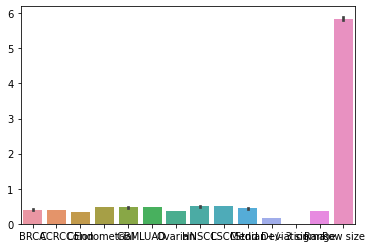

In [8]:
sns.barplot(data = correlation_df)
# sns.barplot(data = pd.DataFrame(correlation_df.loc['A1BG']))

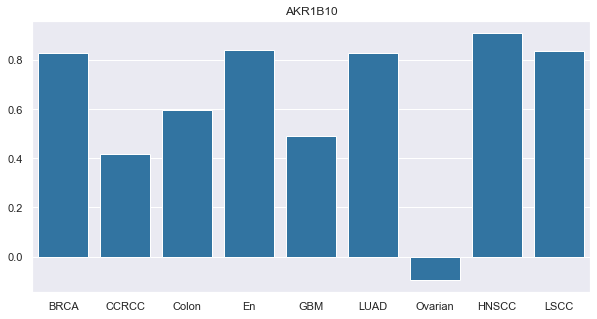

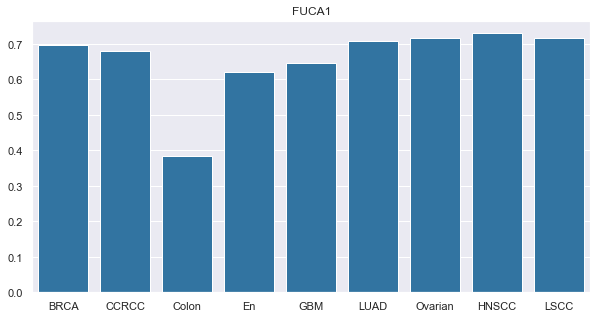

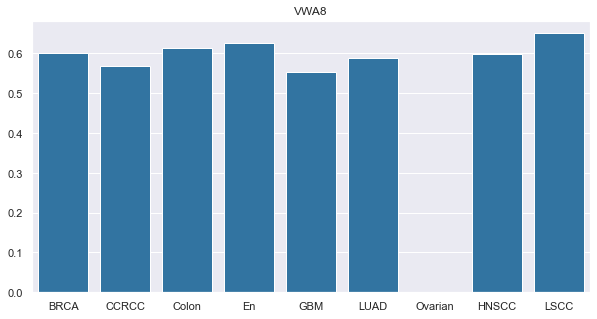

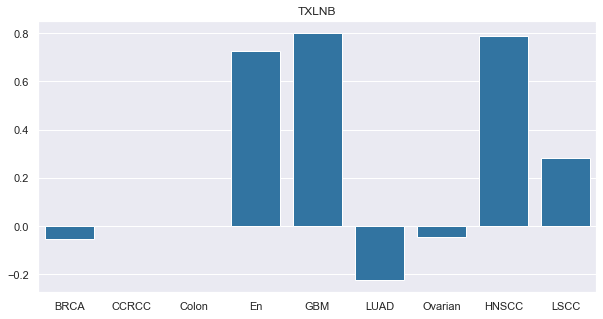

In [9]:
def print_gene_plot(gene_list, color, correlation_df):
    for gene in gene_list:
        data_list = []
        for i in correlation_df:
            if not (i == 'median' or i == 'Stnd Deviation' or i == '+/- 3 sigma' or i == 'Range' or i == 'Row size'):
                data_list.append(correlation_df[i].loc[gene])
        plt.figure(figsize=(10,5))
        df_columns = {'BRCA': (data_list[0]),'CCRCC': (data_list[1]), 
       'Colon': (data_list[2]), 'En': (data_list[3]),
       'GBM': (data_list[4]), 'LUAD': (data_list[5]), 'Ovarian': (data_list[6]),
        'HNSCC' : (data_list[7]), 'LSCC' : (data_list[8])}
        df = pd.DataFrame(df_columns , columns = ['BRCA', 'CCRCC', 'Colon', 'En', 'GBM', 'LUAD', 'Ovarian', 'HNSCC', 'LSCC'], index=[gene])
        sns.set(style="darkgrid")
        if color == 'none':
            sns.barplot(data = df).set_title(gene)
        else:
            sns.barplot(data = df, color = color).set_title(gene)
        
        plt.show()
print_gene_plot(['AKR1B10', 'FUCA1','VWA8','TXLNB'], 'tab:blue',correlation_df)

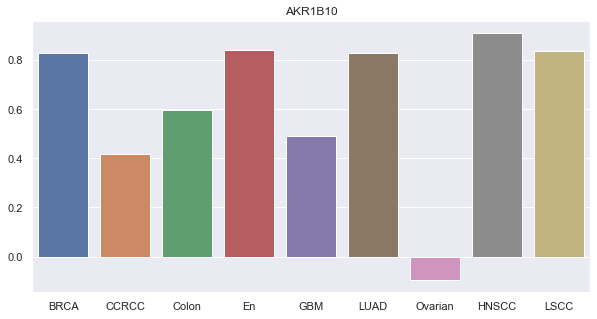

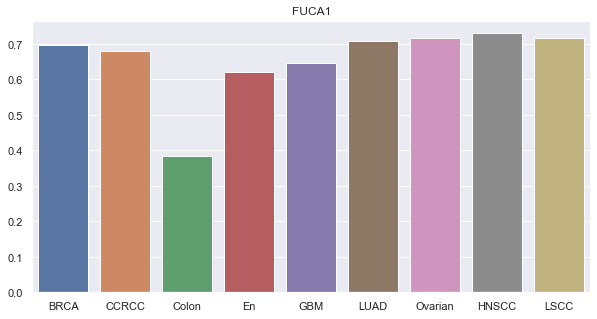

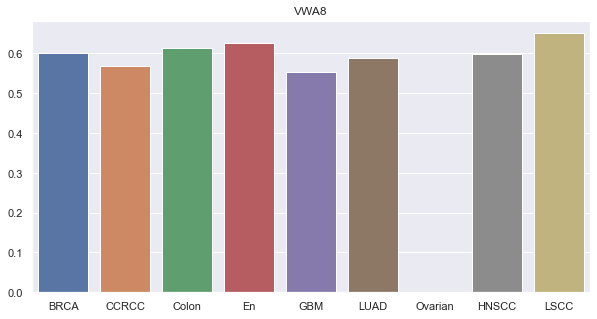

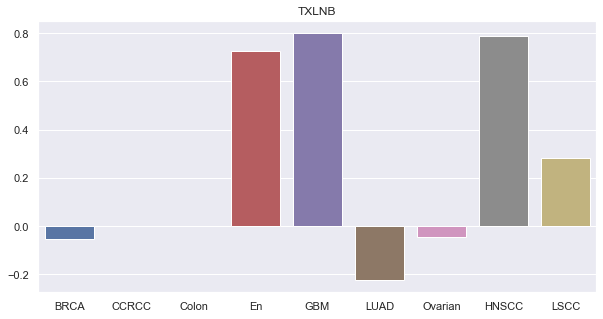

In [10]:
print_gene_plot(['AKR1B10', 'FUCA1','VWA8','TXLNB'], 'none',correlation_df)

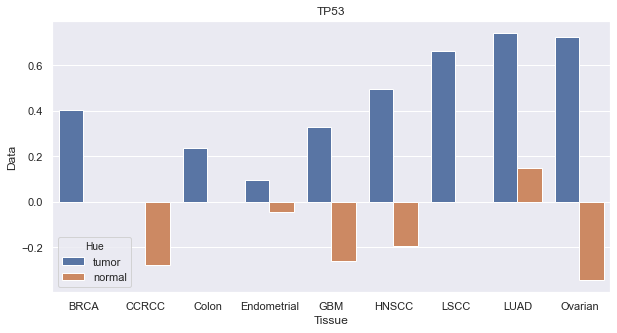

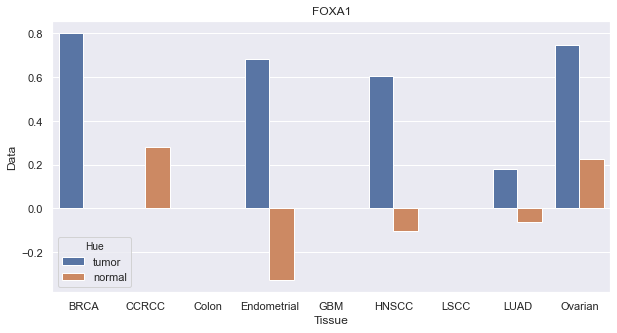

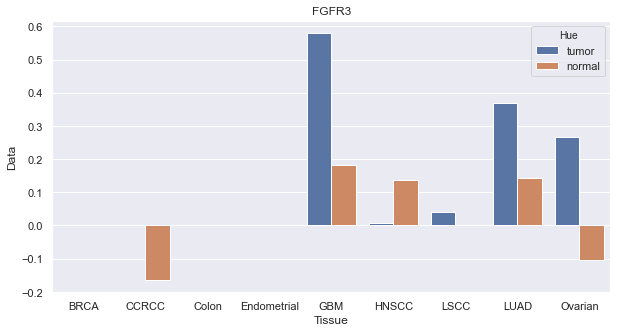

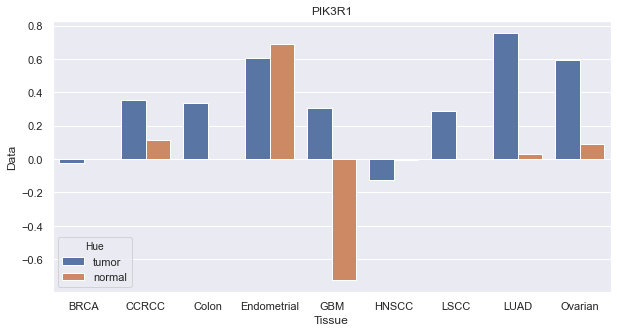

In [11]:
def print_tumor_normal(gene_list, tumor_df, normal_df):
    tissue_list = ['BRCA','CCRCC','Colon','Endometrial','GBM','LUAD','Ovarian','HNSCC','LSCC','BRCA','CCRCC','Colon','Endometrial','GBM','LUAD','Ovarian','HNSCC','LSCC']
    tissue_list = sorted(tissue_list)
    
    hue_list = ['tumor','normal','tumor','normal','tumor','normal','tumor','normal','tumor','normal','tumor','normal','tumor','normal','tumor','normal','tumor','normal']
    
    for gene in gene_list:
        plt.figure(figsize=(10,5))
        tumor_list = []
        normal_list = []
        data_list = []
        for i in tumor_df:
            if not (i == 'Median' or i == 'Stnd Deviation' or i == '+/- 3 sigma' or i == 'Range' or i == 'Row size'):
                
                tumor_list.append(correlation_df[i].loc[gene])
        for i in normal_df:
            if not (i == 'Median' or i == 'Stnd Deviation' or i == '+/- 3 sigma' or i == 'Range' or i == 'Row size'):
                normal_list.append(normal_correlation_df[i].loc[gene])
        for i, j in enumerate(tumor_list):
            data_list.append(tumor_list[i])
            data_list.append(normal_list[i])
        

        df_columns = {'Tissue' : tissue_list, 'Data' : data_list, 'Hue' : hue_list}
        df = pd.DataFrame(df_columns , columns = ['Tissue','Data','Hue'], index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
        sns.barplot(x="Tissue", y="Data", hue="Hue", data=df).set_title(gene)
        plt.show()
print_tumor_normal(['TP53', 'FOXA1','FGFR3','PIK3R1'], correlation_df, normal_correlation_df)